In [1]:
import os

VERSION = '20'
INPUT_DIR = 'data/'
VERSION_DIR = INPUT_DIR + VERSION + '/'
os.makedirs(VERSION_DIR, exist_ok=True)

print(VERSION_DIR)

data/20/


In [2]:
import polars as pl
import pandas as pd
import numpy as np
import math
import gc
from tqdm import tqdm
from math import pi
import pickle
import random
import datetime
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

%load_ext memory_profiler

In [3]:
from utils import pkl_save, pkl_load, get_info

In [4]:
%%time
%%memit

events = (
    pl.read_csv(INPUT_DIR + 'train_events.csv')
    .drop_nulls()
    .with_columns(
        pl.col('event').replace({'onset': 1, 'wakeup': -1}, default=None)
    )
)

peak memory: 149.23 MiB, increment: 13.09 MiB
CPU times: total: 31.2 ms
Wall time: 624 ms


In [5]:
%%time
%%memit

series = (
    pl.read_parquet(INPUT_DIR + 'train_series.parquet')
    .join(
        events[['series_id', 'event', 'timestamp']],
        on=['series_id', 'timestamp'],
        how='left'
    )
    .with_columns(
        pl.col('timestamp').str.to_datetime().dt.replace_time_zone(None),
        pl.col('event').fill_null(0.0),
        (pl.col('enmo') + 0.02).log().alias('enmo_log'),
        (pl.col('anglez').rolling_std(25, center=True).over('series_id') + 1).log().fill_null(0).alias('anglez_std_log')
    )
    .with_columns(
        pl.col('timestamp').dt.time().alias('time'),
    )
    .with_columns(
        (pl.count().over(['series_id', 'time', 'anglez', 'enmo']) - 1).alias('periodicity_flag')
    )
    .with_columns(
        pl.col('periodicity_flag') / pl.col('periodicity_flag').max().clip(1).over('series_id'),
        pl.when(pl.col('periodicity_flag')==0).then(1).otherwise(0).alias('valid_flag')
    )
)

peak memory: 26100.40 MiB, increment: 25950.86 MiB
CPU times: total: 3min 22s
Wall time: 45.4 s


In [6]:
series.filter((series['periodicity_flag']>0) & (series['event']!=0))

series_id,step,timestamp,anglez,enmo,event,enmo_log,anglez_std_log,time,periodicity_flag,valid_flag
str,u32,datetime[μs],f32,f32,f64,f32,f32,time,f64,i32
"""137b99e936ab""",366876,2018-08-09 02:33:00,-19.1861,0.0088,1.0,-3.54738,1.306606,02:33:00,1.0,0
"""148471991ffb""",133644,2019-01-18 11:52:00,-22.792299,0.008,-1.0,-3.575551,1.417929,11:52:00,0.9375,0
"""292a75c0b94e""",108156,2019-03-21 00:28:00,-13.8235,0.0271,1.0,-3.055483,1.645103,00:28:00,0.777778,0
"""3d53bfea61d6""",283476,2019-03-09 02:28:00,-8.3144,0.0736,1.0,-2.368725,1.796374,02:28:00,0.75,0
"""416354edd92a""",90180,2018-11-02 01:00:00,0.1681,0.0274,1.0,-3.049133,3.800322,01:00:00,0.833333,0
"""599ca4ed791b""",176796,2019-02-18 02:33:00,-39.8587,0.0142,1.0,-3.37553,1.02919,02:33:00,0.714286,0
"""5aad18e7ce64""",3420,2018-02-06 02:45:00,-67.500298,0.0213,1.0,-3.186893,2.613216,02:45:00,1.0,0
"""5aad18e7ce64""",9576,2018-02-06 11:18:00,-74.6679,0.0351,-1.0,-2.898606,0.787366,11:18:00,1.0,0
"""60d31b0bec3b""",129600,2019-01-18 04:00:00,-10.6188,0.0169,1.0,-3.299544,3.255308,04:00:00,0.6,0


In [7]:
series_ids = list(set(series['series_id'].unique()) & set(events['series_id'].unique()))
series_ids.sort()
pkl_save(series_ids, VERSION_DIR, 'series_ids')

series_ids.pkl // FILE SIZE: 0 MB


In [8]:
NUM_FEATURES = ['anglez_std_log', 'enmo_log']
CAT_FEATURES = ['periodicity_flag']

info = get_info(series, NUM_FEATURES, VERSION_DIR, 'info')

info.pkl // FILE SIZE: 0 MB


{'anglez_std_log': {'mean': 1.8299718526628137, 'std': 1.1959794759750366},
 'enmo_log': {'mean': -3.165060254585465, 'std': 0.7336516976356506}}

In [9]:
SERIES_SCHEMA = {
    'series_id': pl.Utf8,
    'step': pl.UInt32,
    'timestamp': pl.Datetime,
    'time': pl.Time,
    'anglez_std_log': pl.Float32,
    'enmo_log': pl.Float32,
    'periodicity_flag': pl.Float32,
    'valid_flag': pl.Float32,
    'target': pl.Float32,
    'onset_step': pl.UInt32,
    'wakeup_step': pl.UInt32,
    'onset_night': pl.UInt32,
    'wakeup_night': pl.UInt32,
}

In [10]:
dist_length = 720
sigma = dist_length // 12
n_zeros = 24
dist = np.concatenate([np.arange(1, (dist_length-n_zeros)//2+1)[::-1], np.zeros(n_zeros), np.arange(1, (dist_length-n_zeros)//2+1)])
dist = np.exp(-(dist**2) / (2 * sigma * sigma))

In [11]:
om = [datetime.time(hour, minute, second) for hour in list(range(12, 24)) + list(range(0, 12)) for minute in range(60) for second in range(0, 60, 5)]
om = {t: i for i, t in enumerate(om)}
wm = [datetime.time(hour, minute, second) for hour in list(range(17, 24)) + list(range(0, 17)) for minute in range(60) for second in range(0, 60, 5)]
wm = {t: i for i, t in enumerate(wm)}

In [12]:
%%time
%%memit

dfs = {}
list_onset_Xs = []
list_wakeup_Xs = []
list_onset_df_1min = []
list_wakeup_df_1min = []

for series_id in tqdm(series_ids, total=len(series_ids)):
    
    df = series.filter(series['series_id']==series_id)

    d = df[0, 'timestamp']

    ### onset ###
    on = np.zeros(len(df))
    if d > datetime.datetime(d.year, d.month, d.day, 12, 0):
        ot = datetime.datetime(d.year, d.month, d.day, 12, 0) + datetime.timedelta(days=1) - datetime.datetime(d.year, d.month, d.day, d.hour, d.minute)
        on += 1
    else:
        ot = datetime.datetime(d.year, d.month, d.day, 12, 0) - datetime.datetime(d.year, d.month, d.day, d.hour, d.minute)
    
    for i in range(math.ceil((len(df) - ot.seconds // 5) / (720*24))):
        on[ot.seconds // 5 + 720*24*i:] += 1
    for n in np.unique(on):
        assert (on == n).sum() <= 720*24
        
    ### wakeup ###
    wn = np.zeros(len(df))
    if d > datetime.datetime(d.year, d.month, d.day, 17, 0):
        wt = datetime.datetime(d.year, d.month, d.day, 17, 0) + datetime.timedelta(days=1) - datetime.datetime(d.year, d.month, d.day, d.hour, d.minute)
        wn += 1
    else:
        wt = datetime.datetime(d.year, d.month, d.day, 17, 0) - datetime.datetime(d.year, d.month, d.day, d.hour, d.minute)
    
    for i in range(math.ceil((len(df) - wt.seconds // 5) / (720*24))):
        wn[wt.seconds // 5 + 720*24*i:] += 1
    for n in np.unique(wn):
        assert (wn == n).sum() <= 720*24

    
    df = (
        df
        .with_columns(
            [(pl.col(c) - info[c]['mean']) / info[c]['std'] for c in info]
            +
            [pl.lit(on).alias('onset_night'), 
             pl.lit(wn).alias('wakeup_night'),
             pl.lit(np.convolve(df['event'], dist, mode='same')).alias('target'),
             pl.col('time').replace(om, default=None).alias('onset_step'),
             pl.col('time').replace(wm, default=None).alias('wakeup_step')]
        )
        .with_columns(
            [pl.col(c).cast(SERIES_SCHEMA[c]) for c in SERIES_SCHEMA]
        )
        .select(SERIES_SCHEMA)
    )

    ### onset ###
    list_X_tmp = []
    for c in NUM_FEATURES + CAT_FEATURES:
        df_pivot = (
            df
            .pivot(index='onset_night', columns='onset_step', values=c)
            .select([f'{i}' for i in range(720*24)])
        )
        X_pred = df_pivot.shift(1).fill_null(0).to_numpy()
        X = df_pivot.fill_null(0).to_numpy()
        X_next = df_pivot.shift(-1).fill_null(0).to_numpy()
        X = np.concatenate([X_pred[:, -720:], X, X_next[:, :720]], axis=1)
        list_X_tmp.append(X)
    list_onset_Xs.append(np.stack(list_X_tmp, axis=1))

    df_1min = (
        df
        .sort('timestamp')
        .group_by_dynamic('timestamp', every='1m')
        .agg(
            pl.col('series_id').first(),
            pl.col('onset_night').first(),
            pl.col('onset_step').first(),
            pl.col('step').mean().cast(pl.UInt32),
            pl.col('target').mean(),
            pl.col('valid_flag').max()
        )
    )
    list_onset_df_1min.append(df_1min)

    ### wakeup ###
    list_X_tmp = []
    for c in NUM_FEATURES + CAT_FEATURES:
        df_pivot = (
            df
            .pivot(index='wakeup_night', columns='wakeup_step', values=c)
            .select([f'{i}' for i in range(720*24)])
        )
        X_pred = df_pivot.shift(1).fill_null(0).to_numpy()
        X = df_pivot.fill_null(0).to_numpy()
        X_next = df_pivot.shift(-1).fill_null(0).to_numpy()
        X = np.concatenate([X_pred[:, -720:], X, X_next[:, :720]], axis=1)
        list_X_tmp.append(X)
    list_wakeup_Xs.append(np.stack(list_X_tmp, axis=1))

    df_1min = (
        df
        .sort('timestamp')
        .group_by_dynamic('timestamp', every='1m')
        .agg(
            pl.col('series_id').first(),
            pl.col('wakeup_night').first(),
            pl.col('wakeup_step').first(),
            pl.col('step').mean().cast(pl.UInt32),
            pl.col('target').mean(),
            pl.col('valid_flag').max()
        )
    )
    list_wakeup_df_1min.append(df_1min)
        
    del df
    gc.collect()

del series
gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [17:39<00:00,  3.94s/it]


peak memory: 21734.80 MiB, increment: 3764.98 MiB
CPU times: total: 12min 1s
Wall time: 17min 39s


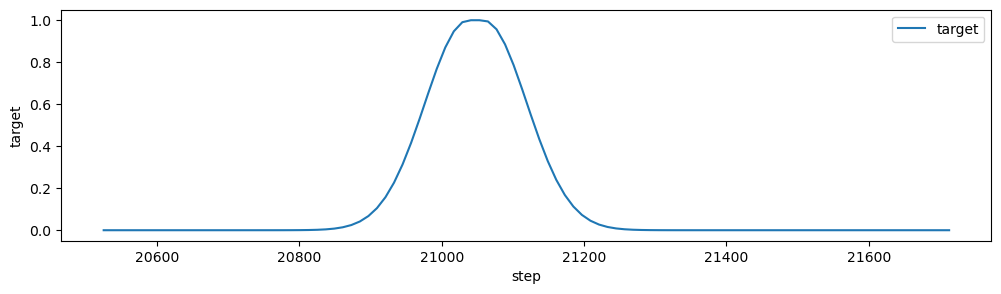

In [13]:
plt.figure(figsize=(12, 3))
plt.plot(df_1min[1710:1810, 'step'], df_1min[1710:1810, 'target'], label='target')
plt.xlabel('step')
plt.ylabel('target')
plt.legend()
plt.show()

In [14]:
Xs = np.concatenate(list_onset_Xs + list_wakeup_Xs)

print(Xs.shape)

del list_onset_Xs, list_wakeup_Xs
gc.collect()

(14912, 3, 18720)


3533

In [15]:
def create_ys_like(list_onset_df_1min, list_wakeup_df_1min, column):
    
    return (
        pl.concat(
            [
                (
                    pl.concat(list_onset_df_1min)
                    .pivot(index=['series_id', 'onset_night'], columns='onset_step', values=column)
                    .with_columns(
                        pl.lit('onset').alias('kind'),
                        pl.col('onset_night').alias('night'),
                    )
                    .select(['series_id', 'kind', 'night'] + [f'{i}' for i in range(0, 720*24, 12)])
                ),
                (
                    pl.concat(list_wakeup_df_1min)
                    .pivot(index=['series_id', 'wakeup_night'], columns='wakeup_step', values=column)
                    .with_columns(
                        pl.lit('wakeup').alias('kind'),
                        pl.col('wakeup_night').alias('night'),
                    )
                    .select(['series_id', 'kind', 'night'] + [f'{i}' for i in range(0, 720*24, 12)])
                )
            ]
        )
        .fill_null(0)
    )

In [16]:
ys = create_ys_like(list_onset_df_1min, list_wakeup_df_1min, 'target')
masks = create_ys_like(list_onset_df_1min, list_wakeup_df_1min, 'valid_flag')
steps = create_ys_like(list_onset_df_1min, list_wakeup_df_1min, 'step')

display(steps.head(5))
display(steps.tail(5))
print()
print(ys.shape)

del list_onset_df_1min, list_wakeup_df_1min
gc.collect()

series_id,kind,night,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240,252,264,276,288,300,312,324,336,348,360,372,384,396,408,420,432,444,456,468,480,492,504,516,528,540,552,…,16680,16692,16704,16716,16728,16740,16752,16764,16776,16788,16800,16812,16824,16836,16848,16860,16872,16884,16896,16908,16920,16932,16944,16956,16968,16980,16992,17004,17016,17028,17040,17052,17064,17076,17088,17100,17112,17124,17136,17148,17160,17172,17184,17196,17208,17220,17232,17244,17256,17268
str,str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""038441c925bb""","""onset""",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,11285,11297,11309,11321,11333,11345,11357,11369,11381,11393,11405,11417,11429,11441,11453,11465,11477,11489,11501,11513,11525,11537,11549,11561,11573,11585,11597,11609,11621,11633,11645,11657,11669,11681,11693,11705,11717,11729,11741,11753,11765,11777,11789,11801,11813,11825,11837,11849,11861,11873
"""038441c925bb""","""onset""",2,11885,11897,11909,11921,11933,11945,11957,11969,11981,11993,12005,12017,12029,12041,12053,12065,12077,12089,12101,12113,12125,12137,12149,12161,12173,12185,12197,12209,12221,12233,12245,12257,12269,12281,12293,12305,12317,12329,12341,12353,12365,12377,12389,12401,12413,12425,12437,…,28565,28577,28589,28601,28613,28625,28637,28649,28661,28673,28685,28697,28709,28721,28733,28745,28757,28769,28781,28793,28805,28817,28829,28841,28853,28865,28877,28889,28901,28913,28925,28937,28949,28961,28973,28985,28997,29009,29021,29033,29045,29057,29069,29081,29093,29105,29117,29129,29141,29153
"""038441c925bb""","""onset""",3,29165,29177,29189,29201,29213,29225,29237,29249,29261,29273,29285,29297,29309,29321,29333,29345,29357,29369,29381,29393,29405,29417,29429,29441,29453,29465,29477,29489,29501,29513,29525,29537,29549,29561,29573,29585,29597,29609,29621,29633,29645,29657,29669,29681,29693,29705,29717,…,45845,45857,45869,45881,45893,45905,45917,45929,45941,45953,45965,45977,45989,46001,46013,46025,46037,46049,46061,46073,46085,46097,46109,46121,46133,46145,46157,46169,46181,46193,46205,46217,46229,46241,46253,46265,46277,46289,46301,46313,46325,46337,46349,46361,46373,46385,46397,46409,46421,46433
"""038441c925bb""","""onset""",4,46445,46457,46469,46481,46493,46505,46517,46529,46541,46553,46565,46577,46589,46601,46613,46625,46637,46649,46661,46673,46685,46697,46709,46721,46733,46745,46757,46769,46781,46793,46805,46817,46829,46841,46853,46865,46877,46889,46901,46913,46925,46937,46949,46961,46973,46985,46997,…,63125,63137,63149,63161,63173,63185,63197,63209,63221,63233,63245,63257,63269,63281,63293,63305,63317,63329,63341,63353,63365,63377,63389,63401,63413,63425,63437,63449,63461,63473,63485,63497,63509,63521,63533,63545,63557,63569,63581,63593,63605,63617,63629,63641,63653,63665,63677,63689,63701,63713
"""038441c925bb""","""onset""",5,63725,63737,63749,63761,63773,63785,63797,63809,63821,63833,63845,63857,63869,63881,63893,63905,63917,63929,63941,63953,63965,63977,63989,64001,64013,64025,64037,64049,64061,64073,64085,64097,64109,64121,64133,64145,64157,64169,64181,64193,64205,64217,64229,64241,64253,64265,64277,…,80405,80417,80429,80441,80453,80465,80477,80489,80501,80513,80525,80537,80549,80561,80573,80585,80597,80609,80621,80633,80645,80657,80669,80681,80693,80705,80717,80729,80741,80753,80765,80777,80789,80801,80813,80825,80837,80849,80861,80873,80885,80897,80909,80921,80933,80945,80957,80969,80981,80993


series_id,kind,night,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240,252,264,276,288,300,312,324,336,348,360,372,384,396,408,420,432,444,456,468,480,492,504,516,528,540,552,…,16680,16692,16704,16716,16728,16740,16752,16764,16776,16788,16800,16812,16824,16836,16848,16860,16872,16884,16896,16908,16920,16932,16944,16956,16968,16980,16992,17004,17016,17028,17040,17052,17064,17076,17088,17100,17112,17124,17136,17148,17160,17172,17184,17196,17208,17220,17232,17244,17256,17268
str,str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""fe90110788d2""","""wakeup""",31,515165,515177,515189,515201,515213,515225,515237,515249,515261,515273,515285,515297,515309,515321,515333,515345,515357,515369,515381,515393,515405,515417,515429,515441,515453,515465,515477,515489,515501,515513,515525,515537,515549,515561,515573,515585,515597,515609,515621,515633,515645,515657,515669,515681,515693,515705,515717,…,531845,531857,531869,531881,531893,531905,531917,531929,531941,531953,531965,531977,531989,532001,532013,532025,532037,532049,532061,532073,532085,532097,532109,532121,532133,532145,532157,532169,532181,532193,532205,532217,532229,532241,532253,532265,532277,532289,532301,532313,532325,532337,532349,532361,532373,532385,532397,532409,532421,532433
"""fe90110788d2""","""wakeup""",32,532445,532457,532469,532481,532493,532505,532517,532529,532541,532553,532565,532577,532589,532601,532613,532625,532637,532649,532661,532673,532685,532697,532709,532721,532733,532745,532757,532769,532781,532793,532805,532817,532829,532841,532853,532865,532877,532889,532901,532913,532925,532937,532949,532961,532973,532985,532997,…,549125,549137,549149,549161,549173,549185,549197,549209,549221,549233,549245,549257,549269,549281,549293,549305,549317,549329,549341,549353,549365,549377,549389,549401,549413,549425,549437,549449,549461,549473,549485,549497,549509,549521,549533,549545,549557,549569,549581,549593,549605,549617,549629,549641,549653,549665,549677,549689,549701,549713
"""fe90110788d2""","""wakeup""",33,549725,549737,549749,549761,549773,549785,549797,549809,549821,549833,549845,549857,549869,549881,549893,549905,549917,549929,549941,549953,549965,549977,549989,550001,550013,550025,550037,550049,550061,550073,550085,550097,550109,550121,550133,550145,550157,550169,550181,550193,550205,550217,550229,550241,550253,550265,550277,…,566405,566417,566429,566441,566453,566465,566477,566489,566501,566513,566525,566537,566549,566561,566573,566585,566597,566609,566621,566633,566645,566657,566669,566681,566693,566705,566717,566729,566741,566753,566765,566777,566789,566801,566813,566825,566837,566849,566861,566873,566885,566897,566909,566921,566933,566945,566957,566969,566981,566993
"""fe90110788d2""","""wakeup""",34,567005,567017,567029,567041,567053,567065,567077,567089,567101,567113,567125,567137,567149,567161,567173,567185,567197,567209,567221,567233,567245,567257,567269,567281,567293,567305,567317,567329,567341,567353,567365,567377,567389,567401,567413,567425,567437,567449,567461,567473,567485,567497,567509,567521,567533,567545,567557,…,583685,583697,583709,583721,583733,583745,583757,583769,583781,583793,583805,583817,583829,583841,583853,583865,583877,583889,583901,583913,583925,583937,583949,583961,583973,583985,583997,584009,584021,584033,584045,584057,584069,584081,584093,584105,584117,584129,584141,584153,584165,584177,584189,584201,584213,584225,584237,584249,584261,584273
"""fe90110788d2""","""wakeup""",35,584285,584297,584309,584321,584333,584345,584357,584369,584381,584393,584405,584417,584429,584441,584453,584465,584477,584489,584501,584513,584525,584537,584549,584561,584573,584585,584597,584609,58


(14912, 1443)


18

In [17]:
pkl_save(Xs, VERSION_DIR, 'Xs')
pkl_save(ys[:, 3:].to_numpy(), VERSION_DIR, 'ys')
pkl_save(masks[:, 3:].to_numpy(), VERSION_DIR, 'masks')
pkl_save(steps.to_pandas(), VERSION_DIR, 'steps')

Xs.pkl // FILE SIZE: 3195 MB
ys.pkl // FILE SIZE: 82 MB
masks.pkl // FILE SIZE: 82 MB
steps.pkl // FILE SIZE: 82 MB


In [18]:
'''import IPython

get_ipython().kernel.do_shutdown(restart=False)'''

'import IPython\n\nget_ipython().kernel.do_shutdown(restart=False)'